In [1]:
import pydicom
from itertools import islice
import numpy as np
import struct

In [2]:
url = "https://github.com/marcodebe/dicom-ecg-plot/blob/master/sample_files/anonymous_ecg.dcm?raw=true"

In [3]:
!curl -L {url} > anonymous_ecg.dcm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   151  100   151    0     0    151      0  0:00:01 --:--:--  0:00:01   508

100   162  100   162    0     0    162      0  0:00:01 --:--:--  0:00:01   162

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  284k  100  284k    0     0   284k      0  0:00:01 --:--:--  0:00:01 3644k


In [4]:
dataset = pydicom.dcmread("anonymous_ecg.dcm")

# 'anonymous_ecg.dcm' was taken from https://github.com/marcodebe/dicom-ecg-plot (see above)

In [5]:
print(str(dataset)[:800])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.20029.40.20130125105919.5407.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.76.13.1.1.1.1
(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20130125'
(0008, 0013) Instance Creation Time              TM: 


In [6]:
dataset.file_meta

(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.20029.40.20130125105919.5407.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.76.13.1.1.1.1
(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'

In [7]:
dataset.file_meta[(0x0002, 0x0013)]

(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'

In [8]:
dataset[0x0008, 0x0005]  # note, keys are hexadecimals

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'

In [9]:
dataset[0x0008, 0x0005].value

'ISO_IR 100'

In [10]:
dataset.SpecificCharacterSet  # here we access the same entry by name

'ISO_IR 100'

In [11]:
dataset.WaveformSequence  # this entry is getting us closer to the actual readings

<Sequence, length 2>

In [12]:
# adapting code from https://github.com/marcodebe/dicom-ecg-plot

sequence_item = dataset.WaveformSequence[0]

assert (sequence_item.WaveformSampleInterpretation == 'SS')
assert (sequence_item.WaveformBitsAllocated == 16)

channel_definitions = sequence_item.ChannelDefinitionSequence
wavewform_data = sequence_item.WaveformData
channels_no = sequence_item.NumberOfWaveformChannels
samples = sequence_item.NumberOfWaveformSamples
sampling_frequency = sequence_item.SamplingFrequency
duration = samples / sampling_frequency

In [13]:
sequence_item.WaveformData[:30]

b'P\x00Z\x00\n\x00\xab\xff#\x002\x00(\x00\x0f\x00\xf6\xff\xec\xff\xc9\xff\xd8\xffA\x00U\x00\x14\x00'

In [14]:
channels_no

12

In [15]:
channel_definitions[0]

(003a, 0208)  Channel Source Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '5.6.3-9-1'
   (0008, 0102) Coding Scheme Designator            SH: 'SCPECG'
   (0008, 0103) Coding Scheme Version               SH: '1.3'
   (0008, 0104) Code Meaning                        LO: 'Lead I (Einthoven)'
   ---------
(003a, 0210) Channel Sensitivity                 DS: "1.25"
(003a, 0211)  Channel Sensitivity Units Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: 'uV'
   (0008, 0102) Coding Scheme Designator            SH: 'UCUM'
   (0008, 0103) Coding Scheme Version               SH: '1.4'
   (0008, 0104) Code Meaning                        LO: 'microvolt'
   ---------
(003a, 0212) Channel Sensitivity Correction Fact DS: "1.0"
(003a, 0213) Channel Baseline                    DS: "0.0"
(003a, 0215) Channel Sample Skew                 DS: "0.0"
(003a, 021a) Waveform Bits Stored                US: 16
(003a, 0220) Filter Low Frequenc

In [16]:
# adapting code from https://github.com/marcodebe/dicom-ecg-plot

def signals():
    factor = np.zeros(channels_no) + 1
    baseln = np.zeros(channels_no)
    units = []
    for idx in range(channels_no):
        definition = channel_definitions[idx]

        assert (definition.WaveformBitsStored == 16)

        if definition.get('ChannelSensitivity'):
            factor[idx] = (
                float(definition.ChannelSensitivity) *
                float(definition.ChannelSensitivityCorrectionFactor)
            )

        if definition.get('ChannelBaseline'):
            baseln[idx] = float(definition.get('ChannelBaseline'))

        units.append(
            definition.ChannelSensitivityUnitsSequence[0].CodeValue
        )

    unpack_fmt = '<%dh' % (len(wavewform_data) / 2)
    unpacked_waveform_data = struct.unpack(unpack_fmt, wavewform_data)
    signals = np.asarray(
        unpacked_waveform_data,
        dtype=np.float32).reshape(
        samples,
        channels_no).transpose()

    for channel in range(channels_no):
        signals[channel] = (
            (signals[channel] + baseln[channel]) * factor[channel]
        )

    high = 40.0

    # conversion factor to obtain millivolts values
    millivolts = {'uV': 1000.0, 'mV': 1.0}

#     for i, signal in enumerate(signals):
#         signals[i] = butter_lowpass_filter(
#             np.asarray(signal),
#             high,
#             self.sampling_frequency,
#             order=2
#         ) / millivolts[units[i]]

    return signals

In [17]:
raw_signals_extracted = signals()

In [18]:
raw_signals_extracted

array([[ 100.  ,   81.25,   62.5 , ...,   25.  ,   21.25,   25.  ],
       [ 112.5 ,  106.25,  100.  , ...,  131.25,  137.5 ,  137.5 ],
       [  12.5 ,   25.  ,   37.5 , ...,  106.25,  116.25,  112.5 ],
       ...,
       [ -25.  ,  -25.  ,  -25.  , ..., -137.5 , -137.5 , -137.5 ],
       [ -68.75,  -75.  ,  -81.25, ..., -150.  , -150.  , -150.  ],
       [ -50.  ,  -50.  ,  -50.  , ..., -100.  , -106.25, -112.5 ]],
      dtype=float32)

In [19]:
raw_signals_extracted.shape

(12, 10000)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
y = pd.Series(raw_signals_extracted[0, :])

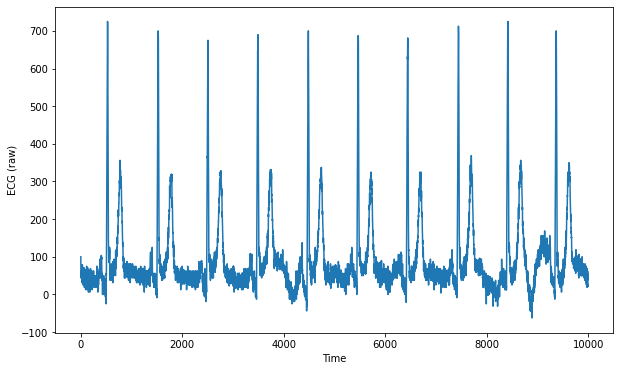

In [22]:
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(1, 1, 1)
y.plot(ax=ax1, label="y")
ax1.set(xlabel="Time", ylabel="ECG (raw)");

In [23]:
ys = [pd.Series(raw_signals_extracted[i, :]) for i in range(raw_signals_extracted.shape[0])]

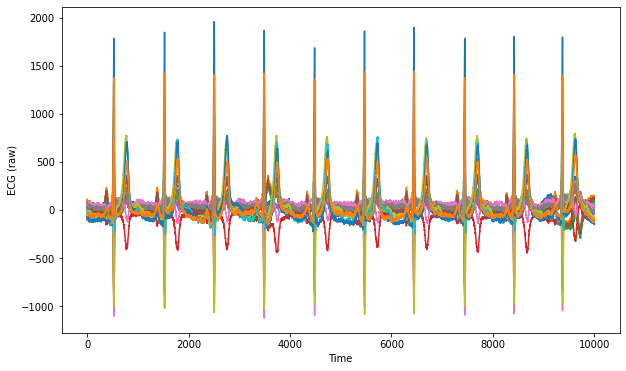

In [24]:
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(1, 1, 1)
for i, y in enumerate(ys):
    y.plot(ax=ax1, label=f'{i}')
ax1.set(xlabel="Time", ylabel="ECG (raw)");

### wrapping above and showing how to create a 3d numpy array

In [25]:
def DICOM_dataset_to_dataframe(dataset):
    series = []
    for i, sequence_item in enumerate(dataset.WaveformSequence):
        assert (sequence_item.WaveformSampleInterpretation == 'SS')
        assert (sequence_item.WaveformBitsAllocated == 16)

        channel_definitions = sequence_item.ChannelDefinitionSequence
        wavewform_data = sequence_item.WaveformData
        channels_no = sequence_item.NumberOfWaveformChannels
        samples = sequence_item.NumberOfWaveformSamples
        sampling_frequency = sequence_item.SamplingFrequency
        duration = samples / sampling_frequency
        
        def signals():
            factor = np.zeros(channels_no) + 1
            baseln = np.zeros(channels_no)
            units = []
            for idx in range(channels_no):
                definition = channel_definitions[idx]

                assert (definition.WaveformBitsStored == 16)

                if definition.get('ChannelSensitivity'):
                    factor[idx] = (
                        float(definition.ChannelSensitivity) *
                        float(definition.ChannelSensitivityCorrectionFactor)
                    )

                if definition.get('ChannelBaseline'):
                    baseln[idx] = float(definition.get('ChannelBaseline'))

                units.append(
                    definition.ChannelSensitivityUnitsSequence[0].CodeValue
                )

            unpack_fmt = '<%dh' % (len(wavewform_data) / 2)
            unpacked_waveform_data = struct.unpack(unpack_fmt, wavewform_data)
            signals = np.asarray(
                unpacked_waveform_data,
                dtype=np.float32).reshape(
                samples,
                channels_no).transpose()

            for channel in range(channels_no):
                signals[channel] = (
                    (signals[channel] + baseln[channel]) * factor[channel]
                )
            
            return signals
        
        raw_signals_extracted = signals()

        for j in range(raw_signals_extracted.shape[0]):
            series.append(pd.Series(raw_signals_extracted[j, :]))
            
    columns = [f'dim_{i}' for i in range(len(series))]
            
    x_data = pd.DataFrame(columns=columns)
    
    return x_data.append(pd.Series(series, index=columns), ignore_index=True)

In [26]:
data = DICOM_dataset_to_dataframe(dataset)

In [27]:
data

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23
0,0 100.00 1 81.25 2 62.50 3...,0 112.50 1 106.25 2 100.00 3...,0 12.50 1 25.00 2 37.50 3...,0 -106.25 1 -93.75 2 -81.25 3...,0 43.75 1 27.50 2 12.50 3 ...,0 62.50 1 65.00 2 68.75 3...,0 50.00 1 50.00 2 50.00 3 ...,0 18.75 1 25.00 2 31.25 3 ...,0 -12.50 1 -12.50 2 -12.50 3...,0 -25.00 1 -25.00 2 -25.00 3...,...,0 87.50 1 87.50 2 62.50 3 ...,0 -56.25 1 -56.25 2 -68.75 3 ...,0 -37.50 1 -37.50 2 -12.50 3 ...,0 93.75 1 93.75 2 81.25 3 ...,0 -50.0 1 -50.0 2 -50.0 3 ...,0 -12.5 1 0.0 2 0.0 3 ...,0 100.0 1 100.0 2 100.0 3 ...,0 112.5 1 112.5 2 112.5 3 ...,0 75.0 1 75.0 2 75.0 3 ...,0 50.0 1 50.0 2 37.5 3 ...


In [28]:
for col in data.iloc[0]:
    print(len(col))

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200
1200


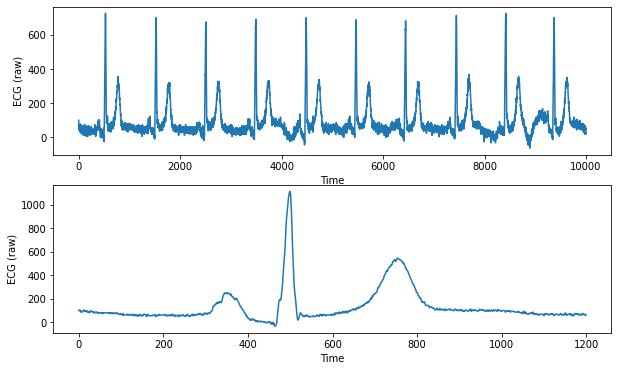

In [29]:
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(2, 1, 1)
data.iloc[0]['dim_0'].plot(ax=ax1, label="dim_0")
ax1.set(xlabel="Time", ylabel="ECG (raw)")
ax2=plt.subplot(2, 1, 2)
data.iloc[0]['dim_13'].plot(ax=ax2, label="dim_13")
ax2.set(xlabel="Time", ylabel="ECG (raw)");